# Model Evaluation (CelebA)

In [1]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from tqdm import tqdm

import sys
sys.path.append('../src/data')
sys.path.append('../src/')
sys.path.append('../src/utils')

from datasets import CelebaDataset, WFLWDataset
import landmark_transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from trainer import Trainer

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")
def generate_predictions(model,
                         dataloader,
                         forward_args = {},
                         numclasses = 5*2,
                         device = torch.device('cuda')):
    y_pred = np.zeros((0,int(numclasses/2), 2))
    y = np.zeros((0,int(numclasses/2), 2))
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            inputs = batch['image'].to(device=device)
            labels = batch['landmarks'].numpy()

            outputs = model(inputs, **forward_args).cpu().view(-1, int(numclasses/2), 2).numpy()  # (batch_size, length, num_classes)
            
            y_pred = np.concatenate((y_pred, outputs), axis=0)
            y = np.concatenate((y, labels), axis=0)
                
    return y_pred, y

Running on device: cuda


In [3]:
celeba_data_loc = '/home/data/celeba/'

train_dataset = CelebaDataset(celeba_data_loc + 'landmarks_train.csv', celeba_data_loc + 'attr_train.csv', celeba_data_loc + 'images/img_celeba',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
val_dataset = CelebaDataset(celeba_data_loc + 'landmarks_val.csv', celeba_data_loc + 'attr_val.csv', celeba_data_loc + 'images/img_celeba',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
test_dataset = CelebaDataset(celeba_data_loc + 'landmarks_test.csv', celeba_data_loc + 'attr_test.csv', celeba_data_loc + 'images/img_celeba',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))

trainloader_params = {
    'dataset': train_dataset,
    'batch_size': 8,
    'shuffle': False
}
train_dataloader = DataLoader(**trainloader_params)

valloader_params = {
    'dataset': val_dataset,
    'batch_size': 4,
    'shuffle': False
}
val_dataloader = DataLoader(**valloader_params)

testloader_params = {
    'dataset': test_dataset,
    'batch_size': 4,
    'shuffle': False
}
test_dataloader = DataLoader(**testloader_params)

# Load Model if outputs already saved

In [ ]:
checkpoint_path = 'PATH'

In [97]:
model_path = checkpoint_path + 'celeba_resnet_adversary_1/checkpoint_1/results.csv'
model_results = pd.read_csv(model_path)

In [98]:
num_landmarks = 5
y = model_results['y'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
y_pred = model_results['y_pred'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
print(y.shape, y_pred.shape)

# To convert into (NxD) just change view

(19962, 5, 2) (19962, 5, 2)


In [99]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=10, marker='.', c='lime')
    plt.axis('off')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


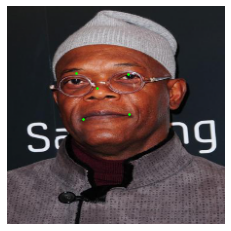

Truth


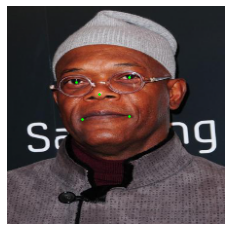

tensor([[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=torch.int32)


In [122]:
#2000, 2300, 5000
img_num = 5000

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()
print(sample['attributes'])

In [101]:
attribute_names = pd.read_csv(celeba_data_loc + 'attr_test.csv')
attribute_names = attribute_names.columns[1:]

In [102]:
attribute_df = pd.read_csv(celeba_data_loc+'attr_test.csv')
class_counts = attribute_df.iloc[:, 1:].apply(pd.Series.value_counts)
biased_classes = class_counts.idxmax()
class_counts

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
-1,17968,14284,10064,15917,19539,16853,13434,15730,14540,17302,...,19036,9975,15772,12695,15837,19123,9544,17209,18563,4848
1,1994,5678,9898,4045,423,3109,6528,4232,5422,2660,...,926,9987,4190,7267,4125,839,10418,2753,1399,15114


In [103]:
# load data and predictions
x = pd.read_csv(celeba_data_loc+'attr_test.csv').values[:, 1:]
y_hat = y_pred

num_samples, num_features = x.shape
assert(y_hat.shape == y.shape)

In [104]:
# define d to be either interocular distance or bounding box diagonal length
d = np.array([1*2**0.5]*num_samples)

In [105]:
d = np.linalg.norm(y_pred[:, 1, :] - y_pred[:, 0, :], axis=1)
print(d)

[0.12025244 0.11434177 0.17029012 ... 0.15543729 0.07123403 0.10077542]


In [106]:
"""
Z = list of lists, where each entry is [sensitive attribute column number, majority condition]
alpha = failure rate threshold   
calculate_landmark: if True, calculates certain bias metrics overall and per landmark. if false, only overall
"""
counts = np.sum(x, axis=0)
maj = np.where(counts > 0, 1, -1)
Z = [[i,maj[i]] for i in range(num_features)]
# calculate_landmark = True

In [107]:
""" Accuracy Metrics: Normalized Mean Error (NME) and CED/AUC/FR
y, y_hat have dimensions of n x m/2 x 2
d is the interocular distance
"""

def calc_nme_images(y_hat, y, m, d):
    # Output: NME of each image over all landmarks (size n)
    nme = np.linalg.norm(y_hat-y, axis=-1) / d[:, np.newaxis]
    return nme.mean(axis=1)

def calc_nme_landmark(y_hat, y, m, d):
    # Output: NME of each image for each facial landmark (size n x m/2)
    nme = np.linalg.norm(y_hat-y, axis=-1) / d[:, np.newaxis]
    return nme

def calc_total_nme(nme):
    # Output: average NME across all images
    return np.mean(nme, axis=0)

def create_ced(nme):
    # Output: plot of the CED
    x = np.sort(nme)
    y = np.arange(nme.shape[0]) / float(nme.shape[0])
    plt.xlabel('Normalized Mean Error (NME)')
    plt.ylabel('Percent of Samples')
  
    plt.title('Plot of Cumulative Error Distribution (CED) Curve')
    plt.plot(x, y, marker='o')
    plt.show

def calc_auc(nme, alpha):
    # Output: percentage of samples with nme=0 to alpha
    num_under_alpha = np.where(nme < alpha, 1, 0)
    return np.sum(num_under_alpha) / nme.shape[0]

def calc_fr(nme, alpha):
    # Output: failure rate, where failure is defined w.r.t a threshold, alpha (percent of samples with nme>alpha)
    return 1-calc_auc(nme, alpha)

In [116]:
#alpha = 0.075
#alpha = 0.007

#alpha = 0.0095
alpha = 0.18
beta = 1
nme_images = calc_nme_images(y_pred, y, num_landmarks, d)
nme_landmark = calc_nme_landmark(y_pred, y, num_landmarks, d)
total_nme = calc_total_nme(nme_images)
total_nme_landmark = calc_total_nme(nme_landmark)

fr = calc_fr(nme_images, alpha)

print('Average Normalized Mean Error:', total_nme, '\n')
print('Average Normalized Mean Error Per Landmark')
for i in range(num_landmarks):
    print(f'Landmark {i}: {total_nme_landmark[i]}')
print('\n')
print(f'Failure Rate Threshold at {alpha}: {fr}')

Average Normalized Mean Error: 0.17092093830699082 

Average Normalized Mean Error Per Landmark
Landmark 0: 0.23424323231310148
Landmark 1: 0.16591083040691434
Landmark 2: 0.1772444275367077
Landmark 3: 0.11593014977926894
Landmark 4: 0.1612760514989632


Failure Rate Threshold at 0.18: 0.2546338042280333


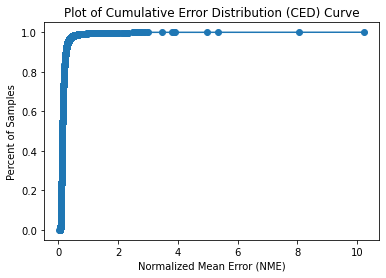

In [117]:
ced = create_ced(nme_images)

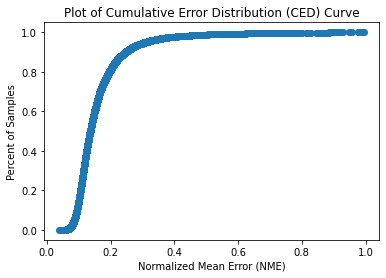

In [118]:
no_outliers = nme_images[np.where(nme_images<beta)]
ced = create_ced(no_outliers)

In [112]:
"""Bias Metrics: Majority/Minority Difference in Error/Failure (MMD)"""
def calc_mmd_err(majority, minority):
    difference = np.mean(majority, axis=0) - np.mean(minority, axis=0)
    return difference

def calc_mmd_fr(majority, minority, alpha):
    difference = calc_fr(majority, alpha) - calc_fr(minority, alpha)
    return difference

In [113]:
""" Within each loop:
z = sensitive attribute group (as column number)
maj = value of majority group
nme = num_samples dimension tensor
"""

mmd_err = {}
mmd_fr = {}


# if calculate_landmark:
#     mmd_error_landmarks = {}

# calculates MMD Error and MMD Failure averaged across all landmarks
for z, maj in Z:
    majority = nme_images[np.where(x[:, z] == maj)] # size # images in majority
    minority = nme_images[np.where(x[:, z] != maj)] # size # images in minority

    mmd_err[z] = calc_mmd_err(majority, minority)
    mmd_fr[z] = calc_mmd_fr(majority, minority, alpha)

# calculates MMD Error for each landmark    
# if calculate_landmark:
#     for z, maj in Z:
#         majority = nme_landmark[np.where(x[:, z] == maj)] # size # images in majority x m/2
#         minority = nme_landmark[np.where(x[:, z] != maj)] # size # images in minority x m/2
#         mmd_error_landmarks[z] = calc_mmd_err(majority, minority)

In [119]:
# 

print('MMD in Error per Attribute')
for z, error in mmd_err.items():
    print(f'Attribute {z} ({attribute_names[z]}): {error}')

MMD in Error per Attribute
Attribute 0 (5_o_Clock_Shadow): 0.02210987788797078
Attribute 1 (Arched_Eyebrows): 0.015035475564493778
Attribute 2 (Attractive): 0.02197234159599351
Attribute 3 (Bags_Under_Eyes): 0.01797252124004936
Attribute 4 (Bald): 0.021444216153169854
Attribute 5 (Bangs): 0.009127913746097976
Attribute 6 (Big_Lips): 0.0019554743190106083
Attribute 7 (Big_Nose): 0.01805611422533901
Attribute 8 (Black_Hair): 0.010131980152458503
Attribute 9 (Blond_Hair): 0.007816783916830716
Attribute 10 (Blurry): -0.11899165220326346
Attribute 11 (Brown_Hair): 0.018687032469210385
Attribute 12 (Bushy_Eyebrows): 0.028302403795600284
Attribute 13 (Chubby): 0.030833274861227777
Attribute 14 (Double_Chin): 0.03353818750043086
Attribute 15 (Eyeglasses): -0.00044206824710943393
Attribute 16 (Goatee): 0.014812394315080885
Attribute 17 (Gray_Hair): 0.0069279815198580175
Attribute 18 (Heavy_Makeup): 0.02464364515068676
Attribute 19 (High_Cheekbones): 0.053564458262470416
Attribute 20 (Male): 0.0

In [115]:
print('MMD in Failure Rate')
for z, error in mmd_fr.items():
    print(f'Attribute {z} ({attribute_names[z]}) : {(error * 100):.3f} % | majority class: {Z[z][1]}')

MMD in Failure Rate
Attribute 0 (5_o_Clock_Shadow) : 5.613 % | majority class: -1
Attribute 1 (Arched_Eyebrows) : 2.334 % | majority class: -1
Attribute 2 (Attractive) : 6.560 % | majority class: -1
Attribute 3 (Bags_Under_Eyes) : 3.534 % | majority class: -1
Attribute 4 (Bald) : 7.417 % | majority class: -1
Attribute 5 (Bangs) : 2.501 % | majority class: -1
Attribute 6 (Big_Lips) : -0.085 % | majority class: -1
Attribute 7 (Big_Nose) : 4.576 % | majority class: -1
Attribute 8 (Black_Hair) : 1.257 % | majority class: -1
Attribute 9 (Blond_Hair) : 3.267 % | majority class: -1
Attribute 10 (Blurry) : -28.973 % | majority class: -1
Attribute 11 (Brown_Hair) : 4.091 % | majority class: -1
Attribute 12 (Bushy_Eyebrows) : 7.707 % | majority class: -1
Attribute 13 (Chubby) : 9.322 % | majority class: -1
Attribute 14 (Double_Chin) : 11.189 % | majority class: -1
Attribute 15 (Eyeglasses) : 1.843 % | majority class: -1
Attribute 16 (Goatee) : 2.633 % | majority class: -1
Attribute 17 (Gray_Hair

In [173]:
cases = [0, 2, 12, 14, 18, 19, 25, 29, 34, 38]
print('MMD in Failure Rate')
acceptable_error = 0.07
for z, error in mmd_fr.items():
    if error > acceptable_error:
        print(f'Attribute {z} ({attribute_names[z]}) : {(error * 100):.3f} % | majority class: {Z[z][1]}')

MMD in Failure Rate
Attribute 0 (5_o_Clock_Shadow) : 7.270 % | majority class: -1
Attribute 12 (Bushy_Eyebrows) : 11.362 % | majority class: -1
Attribute 13 (Chubby) : 8.353 % | majority class: -1
Attribute 14 (Double_Chin) : 10.828 % | majority class: -1
Attribute 19 (High_Cheekbones) : 17.295 % | majority class: -1
Attribute 25 (Oval_Face) : 19.613 % | majority class: -1
Attribute 29 (Rosy_Cheeks) : 15.596 % | majority class: -1
Attribute 34 (Wearing_Earrings) : 8.721 % | majority class: -1
Attribute 38 (Wearing_Necktie) : 9.877 % | majority class: -1


# Train Model (only run once per model)

## Evaluate CelebA

In [72]:
model_path = checkpoint_path + "celeba_resnet_adversary_2/checkpoint_0/model.pt"
model = torch.load(model_path).to(device)

AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [73]:
model = models.resnet18(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5 * 2)
model = model.to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [74]:
y_pred, y = generate_predictions(model, test_dataloader, numclasses=5*2, device=device)

100%|██████████| 4991/4991 [09:10<00:00,  9.07it/s]


In [75]:
data_dict = {
    'y': y.flatten(),
    'y_pred': y_pred.flatten()
}

pred_df = pd.DataFrame(data_dict)
results_csv_path = model_path.replace('model.pt', f'results.csv')
pred_df.to_csv(results_csv_path, index=False)

# Print CelebA predictions

In [76]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=20, marker='.', c='g')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


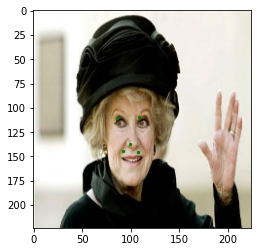

Truth


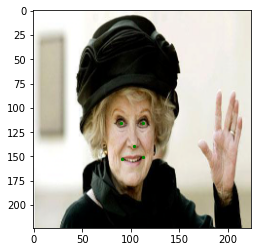

In [77]:
# 0, 1
img_num = 0

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()